## Static interrupt

In [2]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [4]:
# Create Tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [5]:
# Create LLM that can call tools 
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [6]:
sys_msg = SystemMessage(content="Do the required arithmetic using tools or use your own knowledge to answer the query")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [7]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "assistant")
builder.add_edge("assistant", END)


memory = InMemorySaver()
react_graph = builder.compile(interrupt_before=["tools"], checkpointer= memory)


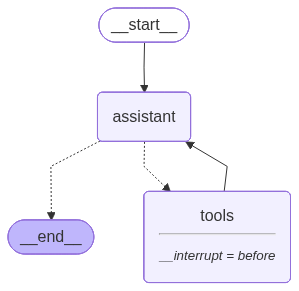

In [8]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

### Example with Tool call and interruption

In [9]:
# Thread
thread = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Add 3 and 4")]
response = react_graph.invoke({"messages": messages}, thread)

In [10]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (93b40624-1680-4439-8e0f-4cd7a2e335bc)
 Call ID: 93b40624-1680-4439-8e0f-4cd7a2e335bc
  Args:
    a: 3
    b: 4


In [11]:
state = react_graph.get_state(thread)
print(state)
print(state.next)

StateSnapshot(values={'messages': [HumanMessage(content='Add 3 and 4', additional_kwargs={}, response_metadata={}, id='246558a0-c186-4b26-a894-3fe8807da106'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3, "b": 4}'}, '__gemini_function_call_thought_signatures__': {'93b40624-1680-4439-8e0f-4cd7a2e335bc': 'CvYBAb4+9vtj02zmER0sblCyhl4L/Xr1/SWyP3sBNl8AIzYrfQYOc8NO3RVRrcljZMmHaeNf97s7CDT+zDk/PMB6V+xP/ejqa6tEktp9hAzSSuUxqTw0xArWZlYPfSP5hP+TTD2Hmj+Neo1gGfPKERf4OHyjIEFGHn4fH8Gr3H1qFMsz++sFCs95L5JRJlEbUEUP6AYmdXO3FwcmFbX387Ggoj9jrlo8NLAzsReDcx9m9ik7wfeaM2DPosONjnNVGTiiOLkTHNsz+gvFawzeU97KzOw9wJsm0cWA1TTnCfIxQIeu5wc0TPdTnv+R1xrzTvSDKqTm1EhM'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--34f727b2-a6ed-43db-b32d-28a8b29a1372-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id

In [12]:
# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    response = react_graph.invoke(None, thread)
    for message in response['messages']:
        message.pretty_print()
else:
    print("Sorry!! Operation cancelled by user.")

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (93b40624-1680-4439-8e0f-4cd7a2e335bc)
 Call ID: 93b40624-1680-4439-8e0f-4cd7a2e335bc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


### Example without tool call

In [32]:
thread2 = {"configurable": {"thread_id": "2"}}

messages = [HumanMessage(content="what is the capital of Germany")]
response = react_graph.invoke({"messages": messages}, thread2)

In [33]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the capital of Germany
================================== Ai Message ==================================

[{'type': 'text', 'text': 'The capital of Germany is Berlin.', 'extras': {'signature': 'CtMBAb4+9vt+x7lUQy/jKLVWbTBk0D3hK4YWcoqLRRCG1celE8daLLLr5K4JvPbQArTAgLTCZUbLiw+Ni8OoFefQSvDMSdZuuR7ctTVMiiTKzVlmMk5xldvMRyph4Gl4UUChNKQ9fmw05HZWPPilb3Aswe5CrhrXDH+9k8NNLqQOdzyb1eVt/CejiSs2yQ1/i9MCgXwV0alxaURSHHBJXLjL8auhNBsOkO3wfy41cCTei1h49bER8Tgw8HUwVFvzc0isLa0P8dVdV2e6coDluICE4BlVzw=='}}]
